In [1]:
# BBGA Data from Amsterdam Municipality: https://bit.ly/2AUicED

import pandas as pd
import matplotlib.pyplot as plt
# import contextily as ctx

from matplotlib.pyplot import figure

In [35]:
file = './bbga_latest_and_greatest-stadsdelen.csv'
bbga = pd.read_csv(file)

# All DX area names in a list for passing to functions
# areas = ['DX0'+str(i) if i < 10 else 'DX'+str(i) for i in range(1,23)]
# areas = ['A', 'B', 'E', 'F', 'K', 'M', 'N', 'T']
areas = ['A', 'E', 'F', 'K', 'M', 'N', 'T']

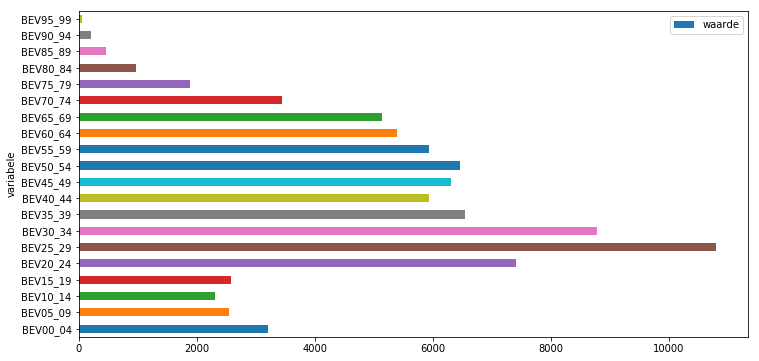

In [12]:
# Creates an age distribution plot for all age groups in a given region and year.

def age_dist(region, year):
    dxareas_bbga = bbga.set_index('gebiedcode15')
    bev_mask = dxareas_bbga.variabele.str.contains('BEV\d?[0|5]_\d?[9|4]{1}\Z')

    age_groups = dxareas_bbga.loc[(bev_mask) & (dxareas_bbga['jaar'] == year) & (dxareas_bbga.index == region)]
    age_groups.reset_index(inplace=True)
    drop_idx = age_groups.loc[(age_groups['variabele'] == 'BEV65_74') | (age_groups['variabele'] == 'BEV40_64')].index
    age_groups.drop(axis='index', index=drop_idx, inplace=True)
    age_groups.loc[age_groups['variabele'] == 'BEV0_4', 'variabele'] = 'BEV00_04'
    age_groups.loc[age_groups['variabele'] == 'BEV5_9', 'variabele'] = 'BEV05_09'
    age_groups = age_groups.sort_values('variabele').set_index('variabele')

    age_groups.plot.barh(y='waarde')
    
age_dist('A', 2017)

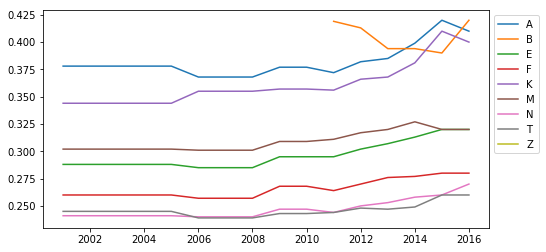

In [14]:
# Creates a connected scatter plot over a particular variable for a given region 
# (right now only plotting gini coefficient)
# Takes in a list of regions, to plot multiple on one graph

# Variables Used
# * IGINI: Gini coefficient, a measure of income inequality

def regions_gini(regions):
    dxareas_bbga = bbga.set_index('gebiedcode15')
    gini_areas = dxareas_bbga.loc[(dxareas_bbga['variabele'] == 'IGINI') & (dxareas_bbga.index.isin(regions))]
    region_ginis = []
    
    for region in regions:
        curr_region = gini_areas[gini_areas.index == region]
        curr_region = pd.concat([curr_region['jaar'], curr_region['waarde']], axis=1).set_index('jaar')
        curr_region.index = pd.to_datetime(curr_region.index, format='%Y')
        curr_region = curr_region.resample('AS').asfreq()
        curr_region.fillna(method='ffill', inplace=True)
        region_ginis.append(curr_region)
        
        plt.plot(curr_region.index, curr_region['waarde'], '-', label=region)
    plt.rcParams["figure.figsize"] = [8, 4]
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.show()
        
regions_gini(areas)

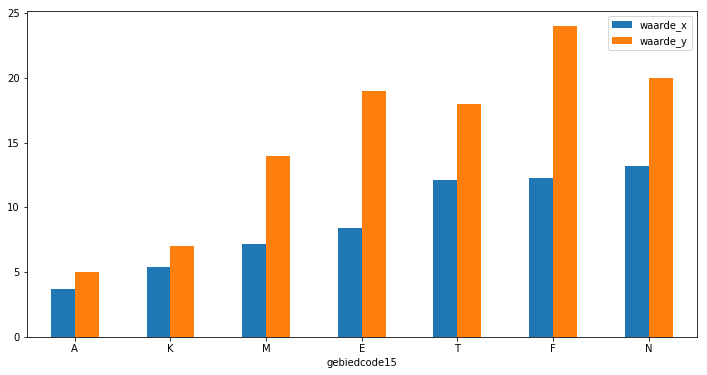

In [22]:
# Creates a barplot that compares, for each region, percentage of school leavers and 
# intolerance for homosexuals

# Variables Used
# * OLSV_P = Percentage of school leavers
# * LNEGAHO_P = Percentage of 4e classers (10th graders), intolerant towards homosexuals

def rank_regions_schoolleavers(year):
    lvrs_regions = bbga.loc[(bbga['variabele'] == 'OLSV_P') & (bbga['gebiedcode15'].isin(areas)) & (bbga['jaar'] == year)].set_index('gebiedcode15')
    homo_tol_youth = bbga.loc[(bbga['variabele'] == 'LNEGAHO_P') & (bbga['gebiedcode15'].isin(areas)) & (bbga['jaar'] == year)].set_index('gebiedcode15')
    lvrs_homotol_df = pd.merge(lvrs_regions, homo_tol_youth, on='gebiedcode15')
    lvrs_homotol_df = lvrs_homotol_df.dropna()[['waarde_x','waarde_y']].sort_values('waarde_x').plot.bar(rot=0)
    plt.rcParams["figure.figsize"] = [12, 6]
    
rank_regions_schoolleavers(2014)

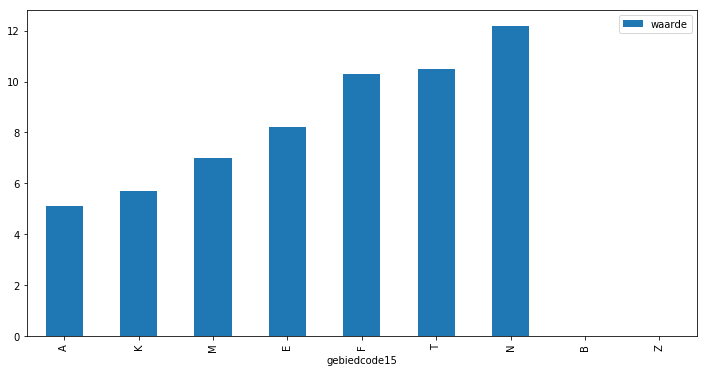

In [23]:
# Creates a barplot comparing all regions' "schoolleavers", percentage of people that never finish high school
# Ranks regions from lowest to highest percentage. Can be used for further investigation in regions.

# Variables Used
# * OLSV_P

def rank_regions_schoolleavers(year):
    lvrs_regions = bbga.loc[(bbga['variabele'] == 'OLSV_P') & (bbga['gebiedcode15'].isin(areas)) & (bbga['jaar'] == year)]
    lvrs_regions = pd.concat([lvrs_regions['gebiedcode15'],lvrs_regions['waarde']], axis=1).set_index('gebiedcode15').sort_values('waarde')
    lvrs_regions.plot.bar()
    
rank_regions_schoolleavers(2017)

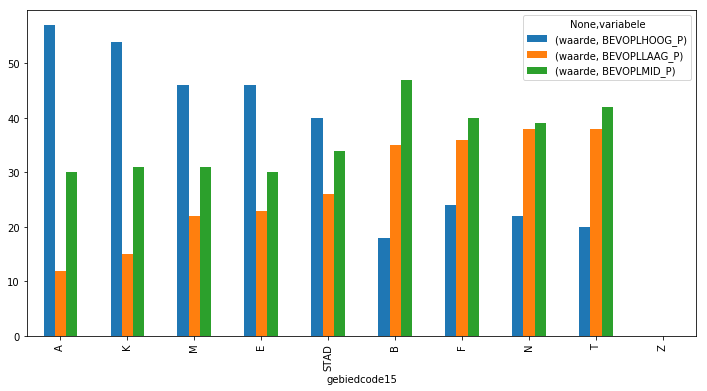

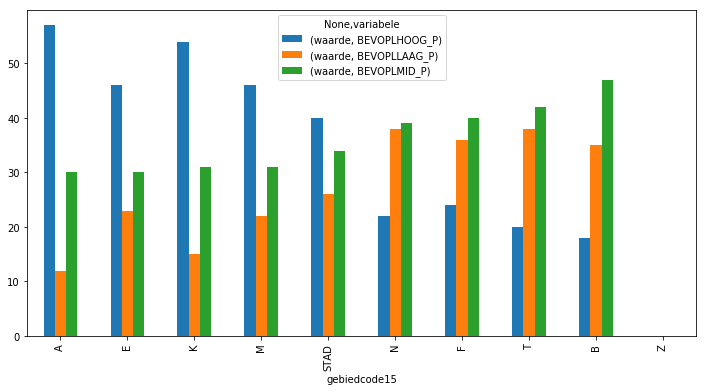

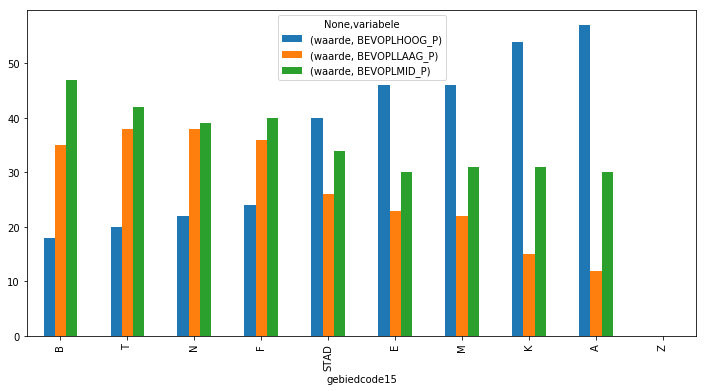

In [24]:
# Creates barplot for all regions in a given year, 
# where each region shows bars for % of high, middle, and low educated population

# Variables Used
# * BEVOPLLAAG_P
# * BEVOPLMID_P
# * BEVOPLHOOG_P

def edu_regions(year):
    mask = bbga.variabele.str.contains('BEVOPL[A-Z]{3,4}_P')
    edu_bbga = bbga.loc[(mask) & (bbga['jaar'] == year)][['gebiedcode15','variabele','waarde']]
    edu_bbga_low = edu_bbga.set_index(['variabele', 'gebiedcode15']).unstack(level=0).sort_values(('waarde','BEVOPLLAAG_P'))
    edu_bbga_low.plot.bar()
    edu_bbga_mid = edu_bbga.set_index(['variabele', 'gebiedcode15']).unstack(level=0).sort_values(('waarde','BEVOPLMID_P'))
    edu_bbga_mid.plot.bar()
    edu_bbga_high = edu_bbga.set_index(['variabele', 'gebiedcode15']).unstack(level=0).sort_values(('waarde','BEVOPLHOOG_P'))
    edu_bbga_high.plot.bar()
    
edu_regions(2014)

In [8]:
# Next idea: Compare distribution of ages between different regions (given a list of regions)
# Perhaps a stacked bar plot would be best, where each stacked bar is for a particular area, and
# each segment in the stack is a certain age group

# Motivation: Perhaps there is more discrimination in regions with older people 

# Age groups: 
# * 0 - 25
# * 26 - 50
# * 51 - 75
# * 76 - 100

def age_dist_regions(regions, year):
    dxareas_bbga = bbga.set_index('gebiedcode15')
    bev_mask = dxareas_bbga.variabele.str.contains('BEV\d?[0|5]_\d?[9|4]{1}\Z')
    year_bbga = dxareas_bbga.loc[(bev_mask) & (dxareas_bbga['jaar'] == year)]
    
    for region in regions:
        region_bbga = year_bbga.loc[year_bbga.index == region]
        print(region_bbga)
        
#     age_groups = dxareas_bbga.loc[(bev_mask) & (dxareas_bbga['jaar'] == year) & (dxareas_bbga.index == region)]
#     age_groups.reset_index(inplace=True)
#     drop_idx = age_groups.loc[(age_groups['variabele'] == 'BEV65_74') | (age_groups['variabele'] == 'BEV40_64')].index
#     age_groups.drop(axis='index', index=drop_idx, inplace=True)
#     age_groups.loc[age_groups['variabele'] == 'BEV0_4', 'variabele'] = 'BEV00_04'
#     age_groups.loc[age_groups['variabele'] == 'BEV5_9', 'variabele'] = 'BEV05_09'
#     age_groups = age_groups.sort_values('variabele').set_index('variabele')

#     age_groups.plot.barh(y='waarde')

#     return year_bbga
    
age_dist_regions(areas[2:5], 2016)

              jaar variabele   waarde
gebiedcode15                         
DX03          2016    BEV0_4   1914.0
DX03          2016  BEV10_14   1163.0
DX03          2016  BEV15_19   1262.0
DX03          2016  BEV20_24   2196.0
DX03          2016  BEV25_29   4191.0
DX03          2016  BEV30_34   4324.0
DX03          2016  BEV35_39   3519.0
DX03          2016  BEV40_44   2949.0
DX03          2016  BEV40_64  12592.0
DX03          2016  BEV45_49   2797.0
DX03          2016  BEV50_54   2730.0
DX03          2016  BEV55_59   2296.0
DX03          2016    BEV5_9   1410.0
DX03          2016  BEV60_64   1820.0
DX03          2016  BEV65_69   1479.0
DX03          2016  BEV65_74   2332.0
DX03          2016  BEV70_74    853.0
DX03          2016  BEV75_79    557.0
DX03          2016  BEV80_84    348.0
DX03          2016  BEV85_89    181.0
DX03          2016  BEV90_94    101.0
DX03          2016  BEV95_99     20.0
              jaar variabele  waarde
gebiedcode15                        
DX04          

In [64]:
import geopandas as gpd
# import contextily as ctx

fp = './mapdata/stadsdelen/sd2010zw_region.shp'

map_df = gpd.read_file(fp)
map_df
# map_df.plot()

# def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
#     xmin, xmax, ymin, ymax = ax.axis()
#     basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
#     ax.imshow(basemap, extent=extent, interpolation='bilinear')
#     # restore original x/y limits
#     ax.axis((xmin, xmax, ymin, ymax))
    
# ax = map_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
# add_basemap(ax, zoom=10)

,SD,STADSDEELN,ZORG,OPP,EZGEBIED,SD09,SDNUMMER,PERCENTAGE,geometry
0,A,Centrum,5,804,C,A,1,7.6,"POLYGON ((123665.8050000036 486606.6800000035,..."
1,B,Westpoort,5,3521,W,B,2,4.2,"POLYGON ((119438.0650000036 492024.1800000035,..."
2,E,West,5,987,RW,E,3,6.6,"POLYGON ((120145.3100000036 487404.4000000035,..."
3,F,Nieuw-West,3,3229,NW,F,4,4.5,"POLYGON ((117410.5450000036 487396.4250000035,..."
4,K,Zuid,4,1736,Z,K,5,5.9,"POLYGON ((122552.0000000036 484781.0100000036,..."
5,M,Oost,6,3023,RO,M,6,6.6,"POLYGON ((121451.3950000036 481892.0800000035,..."
6,N,Noord,1,6360,N,N,7,4.2,"POLYGON ((121947.4950000036 488232.2050000035,..."
7,T,Zuidoost,2,2204,ZO,T,8,3.8,"POLYGON ((124534.3650000036 481233.5100000036,..."


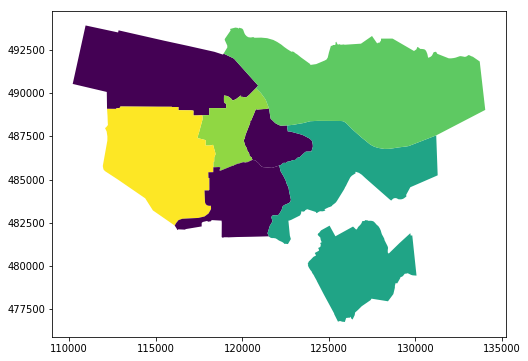

In [72]:
def homo_plot(regions, year):
    regex = '['
    for i, region in enumerate(regions):
        if i == len(regions) - 1:
            regex += region + ']{1}\Z'
        else:
            regex += region + '|'

    mask = bbga.gebiedcode15.str.contains(regex)
    homo_bbga = bbga.loc[(mask) & (bbga['jaar'] == year) & (bbga['variabele'] == 'LNEGAHO_P')][['gebiedcode15','waarde']]
    return map_df.merge(left_on='SD',right_on='gebiedcode15',right=homo_bbga, how='outer').ffill().plot(column='waarde')
    
homo_plot(areas, 2015)
# gdp.choropleth()




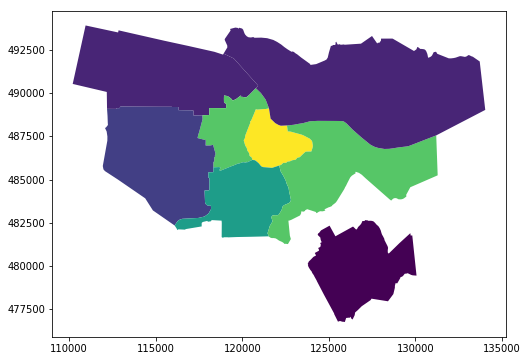

In [51]:
map_df.plot(column='PERCENTAGE')

In [28]:
# Runs into same multi index error

# Change in acceptance and tolerance of homosexuals
# LNEGAHO_P - neg homo
# O_OPLPO_L_P
# O_OPLPO_M_P
# O_OPLPO_P

def corr_edu_par_homo(region):
    dxareas_bbga = bbga.set_index('gebiedcode15')
    bev_mask = dxareas_bbga.variabele.str.contains('O_OPLPO_')
    
    age_groups = dxareas_bbga.loc[(bev_mask) & (dxareas_bbga.index == region)]
    age_groups = age_groups.reset_index()
    age_groups['jaar'] = pd.to_datetime(age_groups['jaar'], format='%Y')
#     age_groups = age_groups.set_index('jaar')

    age_groups = age_groups.groupby(['variabele', 'jaar']).sum()
    age_groups = age_groups.resample('AS', level=1).asfreq()
    return age_groups
    
corr_edu_par_homo('DX20')
    
# df = df.reset_index()
# df['ts'] = pd.to_datetime(df['Timestamp'])
# # 'ts' is now datetime of 'Timestamp', you just need to set it to index
# df = df.set_index('ts')

gebiedcode15
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
STAD    False
        ...  
Z       False
T       False
N       False
A       False
B       False
K       False
F       False
E       False
Z       False
T       False
N       False
M       False
A       False
B       False
E       False
Z       False
T       False
N       False
M       False
K       False
F       False
A       False
B       False
T       False
Z       False
N       False
M       False
K       False
E       False
F       False
Name: variabele, Length: 57027, dtype: bool

In [ ]:
# This function has been updated to work with lists of regions

def regions_gini_old(region):
    dxareas_bbga = bbga.set_index('gebiedcode15')
    gini_bbga = dxareas_bbga.loc[(dxareas_bbga['variabele'] == 'IGINI')  & (dxareas_bbga.index == region)]
    gini_bbga = pd.concat([gini_bbga['jaar'],gini_bbga['waarde']], axis=1)
    gini_bbga = gini_bbga.set_index('jaar')
    gini_bbga.index = pd.to_datetime(gini_bbga.index, format='%Y')
    gini_bbga = gini_bbga.resample('AS').asfreq()
    gini_bbga.fillna(method='ffill', inplace=True)
    gini_bbga.plot.line(style='b')

regions_neg_homo('DX12')

In [ ]:
# This is the function that is running into multi index resampling error

# Change in acceptance and tolerance of homosexuals
# LNEGAHO_P - neg homo
# O_OPLPO_L_P
# O_OPLPO_M_P
# O_OPLPO_P

def corr_edu_par_homo(region):
    dxareas_bbga = bbga.set_index('gebiedcode15')
    bev_mask = dxareas_bbga.variabele.str.contains('O_OPLPO_')
    
    age_groups = dxareas_bbga.loc[(bev_mask) & (dxareas_bbga.index == region)]
    age_groups = age_groups.reset_index()
    age_groups['jaar'] = pd.to_datetime(age_groups['jaar'], format='%Y')
#     age_groups = age_groups.set_index('jaar')

    age_groups = age_groups.groupby(['variabele', 'jaar']).sum()
    age_groups = age_groups.resample('AS', level=1).asfreq()
    return age_groups
    
corr_edu_par_homo('DX20')
    
# df = df.reset_index()
# df['ts'] = pd.to_datetime(df['Timestamp'])
# # 'ts' is now datetime of 'Timestamp', you just need to set it to index
# df = df.set_index('ts')